## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.17.6-cp311-cp311-macosx_11_0_arm64.whl size=246669 sha256=b0a289970e0ec133447044693fc96af2da767302d7264a4c976bd25857ae8392
  Stored in directory: /Users/rynn/Library/Caches/pip/wheels/1c/09/7e/9f659fde248ecdc1722a142c1d744271aad3914a0afc191058
Successfully built peewee


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [6]:
df = yf.download('005930.KS','2018-10-01','2024-10-01')

[*********************100%***********************]  1 of 1 completed


In [7]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-01,46450.0,46800.0,45800.0,46350.0,39669.703125,6354983
2018-10-02,46450.0,46700.0,45700.0,45700.0,39113.375000,6607188
2018-10-04,45150.0,45600.0,44700.0,44700.0,38257.511719,11865327
2018-10-05,44800.0,45500.0,44550.0,44700.0,38257.511719,10544165
2018-10-08,44200.0,45200.0,44200.0,44950.0,38471.472656,6759464
...,...,...,...,...,...,...
2024-09-24,62800.0,63400.0,62400.0,63200.0,63200.000000,26957500
2024-09-25,63800.0,64200.0,62200.0,62200.0,62200.000000,28652438
2024-09-26,63900.0,64900.0,63700.0,64700.0,64700.000000,37566015


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [8]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [10]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-01,46450.0,46800.0,45800.0,46350.0,39669.703125,6354983
2018-10-02,46450.0,46700.0,45700.0,45700.0,39113.375000,6607188
2018-10-04,45150.0,45600.0,44700.0,44700.0,38257.511719,11865327
2018-10-05,44800.0,45500.0,44550.0,44700.0,38257.511719,10544165
2018-10-08,44200.0,45200.0,44200.0,44950.0,38471.472656,6759464
...,...,...,...,...,...,...
2024-09-24,62800.0,63400.0,62400.0,63200.0,63200.000000,26957500
2024-09-25,63800.0,64200.0,62200.0,62200.0,62200.000000,28652438
2024-09-26,63900.0,64900.0,63700.0,64700.0,64700.000000,37566015


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

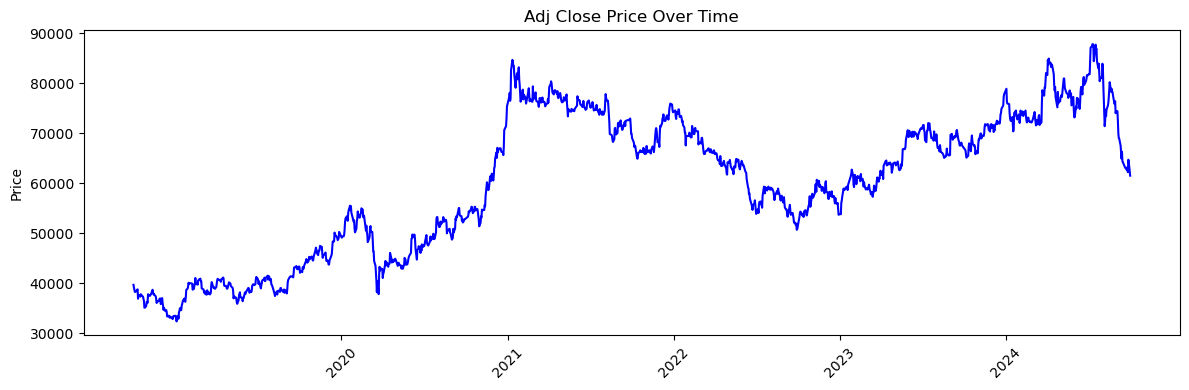

In [21]:
# 수정종가 그래프
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Adj Close'], color='blue', label='Adj Close')
plt.title('Adj Close Price Over Time')
plt.ylabel('Price')
plt.xticks([pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'),
            pd.Timestamp('2022-01-01'), pd.Timestamp('2023-01-01'),
            pd.Timestamp('2024-01-01')],
           [2020, 2021, 2022, 2023, 2024], rotation=45)

plt.tight_layout()
plt.show()

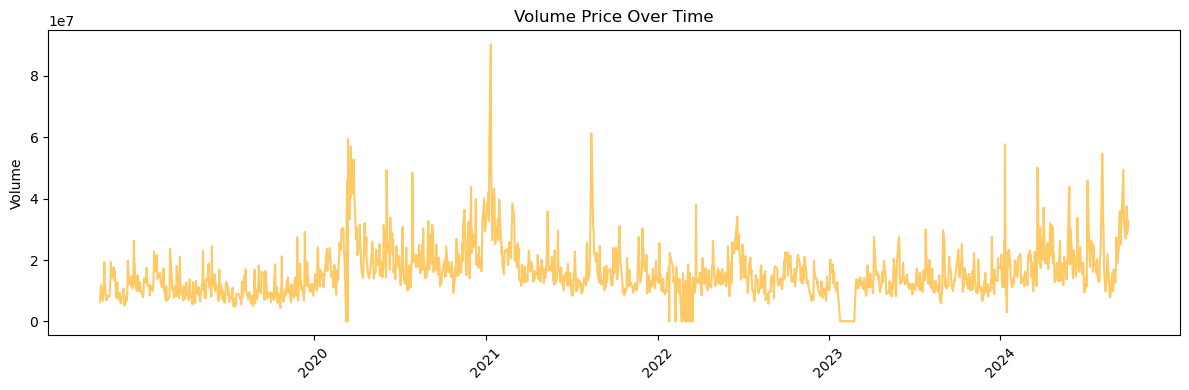

In [22]:
# 거래량 그래프
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Volume'], color='orange', alpha=0.6, label='Volume')
plt.title('Volume Price Over Time')
plt.ylabel('Volume')
plt.xticks([pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'),
            pd.Timestamp('2022-01-01'), pd.Timestamp('2023-01-01'),
            pd.Timestamp('2024-01-01')],
           [2020, 2021, 2022, 2023, 2024], rotation=45)

plt.tight_layout()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

-> 수정종가가 높아지면 거래량도 늘어나는 경향이 보인다. 상관관계가 있는 것 같다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

-> 시계열 데이터가 정상적이라는 것은 데이터의 통계적 특성이 시간에 따라 변하지 않는다는 것을 의미한다. 즉, 평균, 분산, 자기공분산 등이 시간에 따라 일정하게 유지되는 것이다. 예측의 신뢰성을 위해 시계열 데이터에서 정성성은 중요하다. 비정상성을 해결하기 위해서는 로그변환, 차분, 스무딩 등의 방법을 사용할 수 있다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [25]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정 수행
result = adfuller(df['Adj Close'])

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.7674017938710167
p-value: 0.3967616276752698


2.3 ADF Test 결과를 해석하세요.

-> ADF 값이 임계값보다 크고, p-value도 0.05보다 크기 때문에 수정종가 데이터는 정상성이 없으며, 비정상적인 시계열 데이터임을 나타낸다. 

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

- ACF는 전체 시간 지연에서의 상관관계를 보여줌
- PACF는 특정 지연에서의 상관관계만을 보여주며, 중간 지연의 영향을 제거

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

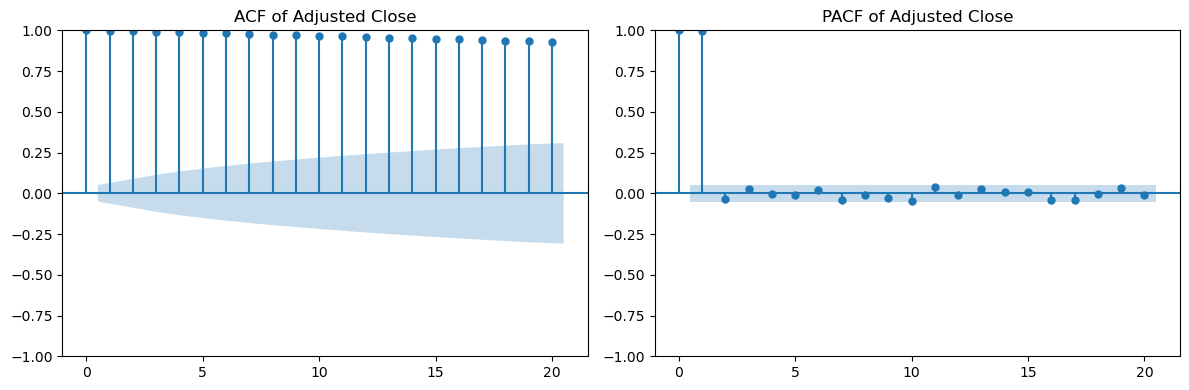

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))

# ACF 그래프
plt.subplot(1, 2, 1)  
plot_acf(df['Adj Close'], lags=20, ax=plt.gca())
plt.title('ACF of Adjusted Close')

# PACF 그래프
plt.subplot(1, 2, 2)  
plot_pacf(df['Adj Close'], lags=20, ax=plt.gca())
plt.title('PACF of Adjusted Close')

plt.tight_layout() 
plt.show()

2.6 결과를 해석하세요.

- 모델링:
ACF와 PACF의 결과를 바탕으로, ARIMA 모델을 구축할 때 AR(자기 회귀) 부분은 1차로 설정할 수 있을 것 같으며, MA(이동 평균) 부분은 ACF의 패턴에 따라 결정해야 할 것 같다.
- 비정상성:
ACF의 패턴이 긴 지연까지 상관관계를 보이고, PACF가 1차 지연 이후 급격히 감소하는 점은 데이터가 비정상적일 가능성을 시사한다. 따라서 차분(differencing) 등의 방법을 통해 정상성을 확보해야 할 필요가 있다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

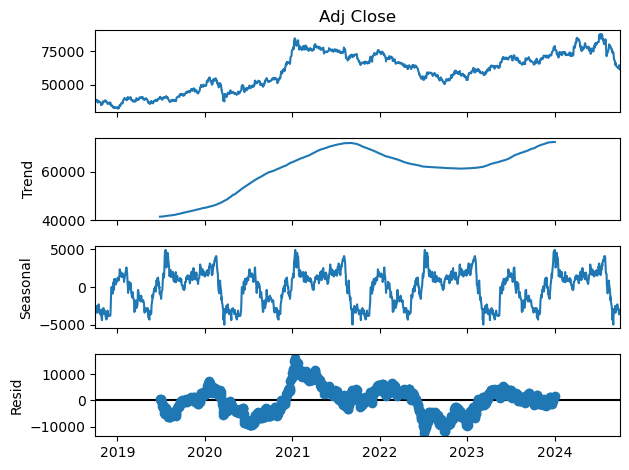

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

ac = df['Adj Close']

decomposition = seasonal_decompose(ac, model='additive', period=365)
decomposition.plot()
plt.show()

2.8 위 결과를 해석하세요.

- 원본 데이터 (Adj Close): 전체적으로 상승하는 경향이 있으며, 몇 가지 급격한 변동이 관찰됨. 이는 주식 시장의 불안정성과 변동성을 반영
- 추세 (Trend): 전반적으로 상승하는 추세, 특히 2020년 이후로 상승 폭이 커지는 경향이 있으며, 이는 특정 경제적 요인이나 시장 상황에 따른 결과일 수 있음
- 계절성 (Seasonal): 그래프에서 주기적인 패턴이 나타나며, 특정 주기로 반복되는 경향
- 잔차 (Residual): 원본 데이터에서 추세와 계절성을 제거한 후 남은 부분으로, 잔차는 무작위적이며 패턴이 없어야 한다. 이 그래프에서는 잔차가 시간에 따라 변동하는 경향이 있으며, 평균이 0에 가까운 값을 유지하고 있음. 그러나 일부 시점에서는 잔차가 크게 증가하거나 감소하는 경우도 있음.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

-> 차분(differencing)은 시계열 데이터에서 현재 값과 이전 값의 차이를 계산하여 비정상성을 제거하고 정상성을 확보하는 방법. 주로 1차 차분(첫 번째 값과 두 번째 값의 차이) 또는 2차 차분(1차 차분의 차이)을 사용하여 데이터를 변환.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [45]:
# 1차 차분 수행
df['Adj Close Diff'] = df['Adj Close'].diff()

# ADF 테스트 수행
result = adfuller(df['Adj Close Diff'].dropna())

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -27.92886989056147
p-value: 0.0


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

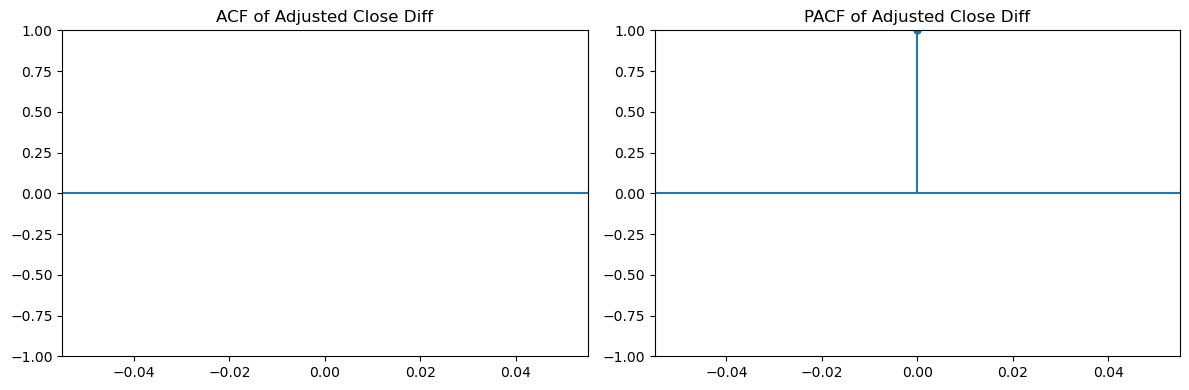

In [46]:
plt.figure(figsize=(12, 4))

# ACF 그래프
plt.subplot(1, 2, 1)  
plot_acf(df['Adj Close Diff'], lags=20, ax=plt.gca())
plt.title('ACF of Adjusted Close Diff')

# PACF 그래프
plt.subplot(1, 2, 2)  
plot_pacf(df['Adj Close Diff'], lags=20, ax=plt.gca())
plt.title('PACF of Adjusted Close Diff')

plt.tight_layout() 
plt.show()

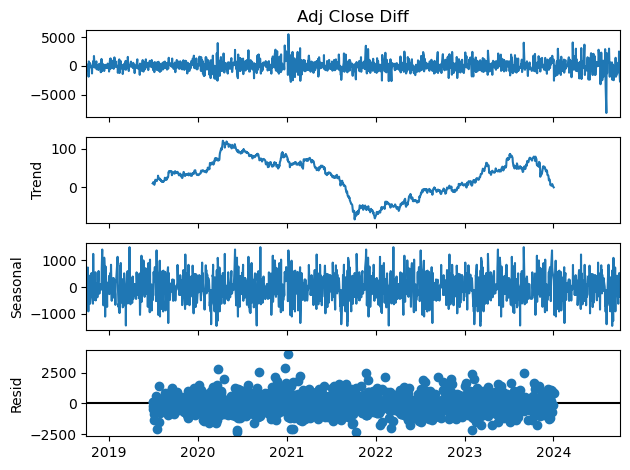

In [49]:
ac_d = df['Adj Close Diff'].dropna()

decomposition = seasonal_decompose(ac_d, model='additive', period=365)
decomposition.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
data['Adj Close_diff']

Date
2019-01-02         NaN
2019-01-03   -3.760181
2019-01-04    1.450996
2019-01-07   -0.078880
2019-01-08    0.674103
                ...   
2023-12-22   -1.075882
2023-12-26   -0.547943
2023-12-27    0.099625
2023-12-28    0.428375
2023-12-29   -1.046036
Name: Adj Close_diff, Length: 1258, dtype: float64

In [24]:
model = ARIMA(data['Adj Close_diff'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1258
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2858.574
Date:                Tue, 27 Aug 2024   AIC                           5727.148
Time:                        23:58:51   BIC                           5752.834
Sample:                             0   HQIC                          5736.801
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1227      0.062      1.969      0.049       0.001       0.245
ar.L1         -0.0434      0.022     -1.986      0.047      -0.086      -0.001
ar.L2         -0.0264      0.023     -1.162      0.245      -0.071       0.018
ar.L3         -0.0158      0.024     -0.658      0.511      -0.063       0.031
sigma2         5.5310      0.149     37.232      0.000       5.240       5.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               349.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


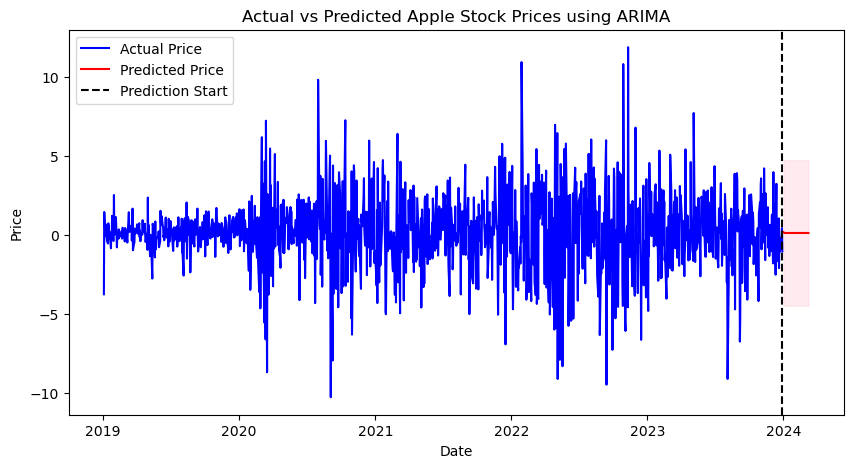

In [26]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%%**********************]  1 of 1 completed


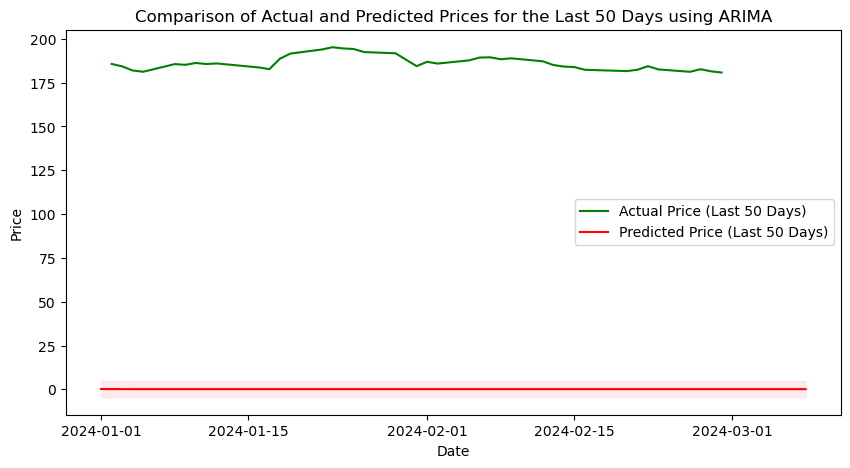

In [29]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [30]:
from prophet import Prophet

In [31]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [33]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

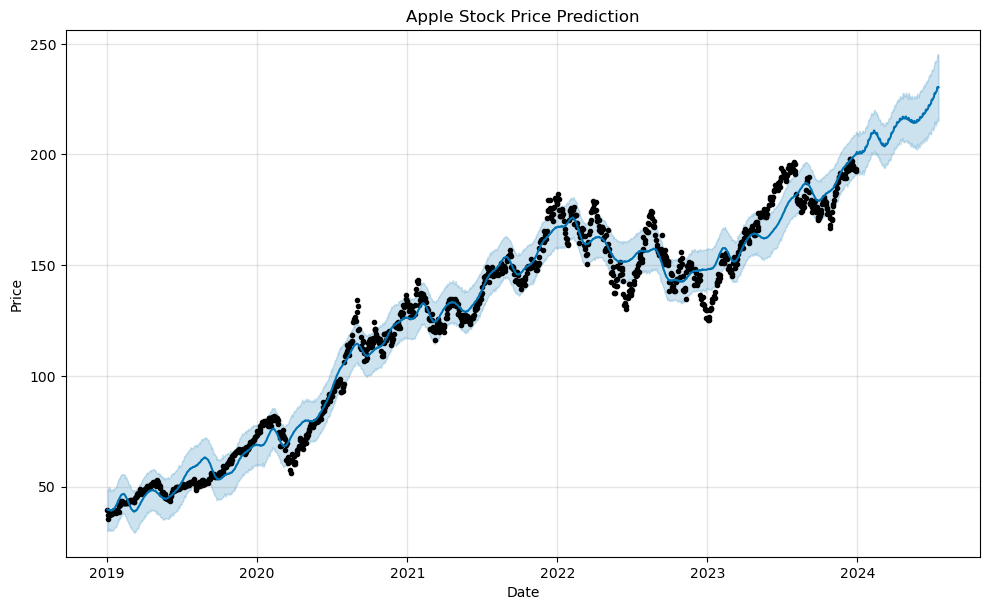

In [35]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

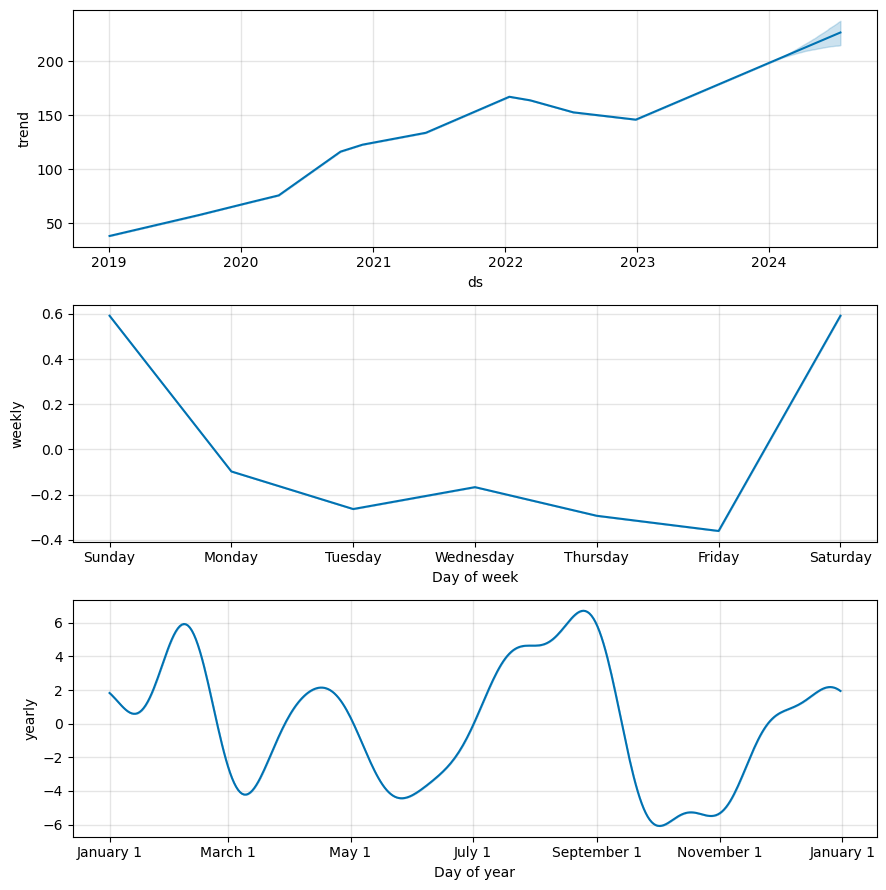

In [36]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [37]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


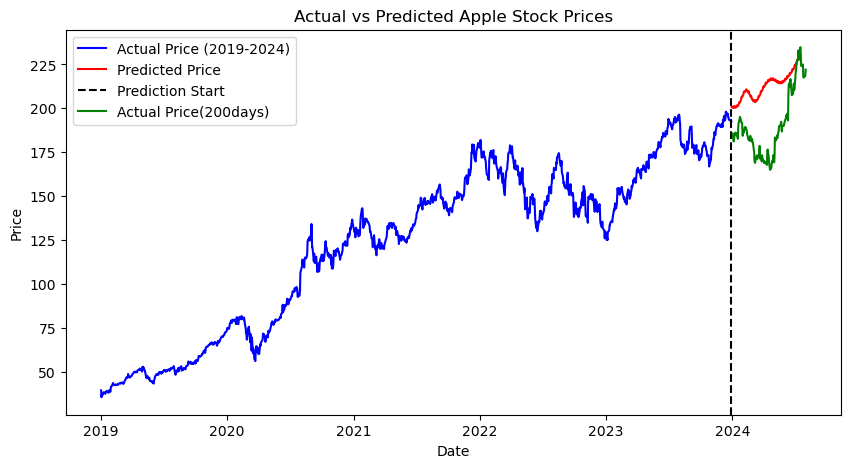

In [41]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.